In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


corrientes = pd.read_csv('corrientes.csv')
potencias = pd.read_csv('potencias.csv')

corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
merged_df = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
merged_df['año'] = merged_df['timestamp'].dt.year
merged_df['mes'] = merged_df['timestamp'].dt.month
merged_df['dia'] = merged_df['timestamp'].dt.day
merged_df['hora'] = merged_df['timestamp'].dt.hour
merged_df['minuto'] = merged_df['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = merged_df[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(final_df)

         año  mes  dia  hora  minuto  activa  reactiva  aparente     l1  \
0       2021    1    1     0       0  13.584     9.264    16.444  29.16   
1       2021    1    1     0      15  12.492     9.840    15.904  27.30   
2       2021    1    1     0      30  12.468    10.056    16.016  27.12   
3       2021    1    1     0      45  13.032     9.060    15.872  27.18   
4       2021    1    1     1       0  12.540     9.720    15.868  27.12   
...      ...  ...  ...   ...     ...     ...       ...       ...    ...   
117200  2024    5    6     8      45  45.840     3.564    45.980  74.16   
117201  2024    5    6     9       0  52.092     3.084    52.184  77.97   
117202  2024    5    6     9      15  51.996     2.448    52.052  74.55   
117203  2024    5    6     9      30  53.472     2.316    53.524  77.43   
117204  2024    5    6     9      45  59.472     2.280    59.516  82.71   

            l2     l3  
0        25.62  20.85  
1        24.81  20.34  
2        25.56  20.64  
3  

#
aa
#Ver
#
ss

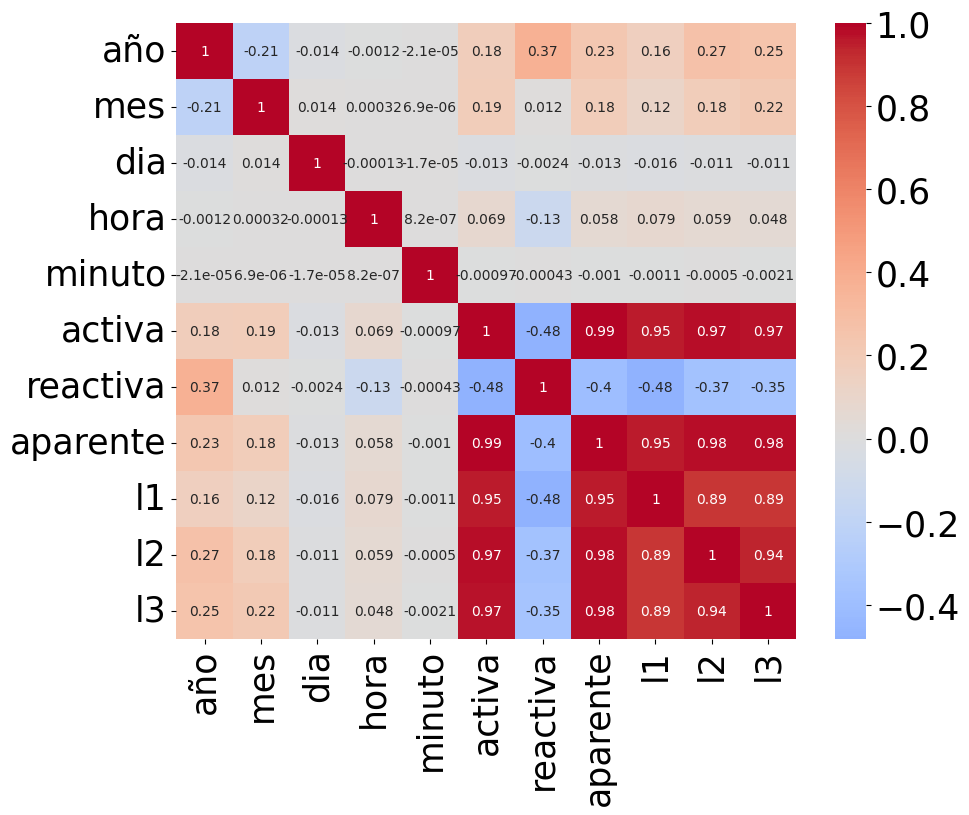

año         0.175960
mes         0.187779
dia        -0.012915
hora        0.068827
minuto     -0.000972
activa      1.000000
reactiva   -0.481186
aparente    0.994164
l1          0.950231
l2          0.972447
l3          0.968129
Name: activa, dtype: float64


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = final_df.corr()

# Generar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Mostrar el mapa de calor
plt.show()

# Mostrar las correlaciones con la potencia activa
print(corr_matrix['activa'])

<function matplotlib.pyplot.show(close=None, block=None)>

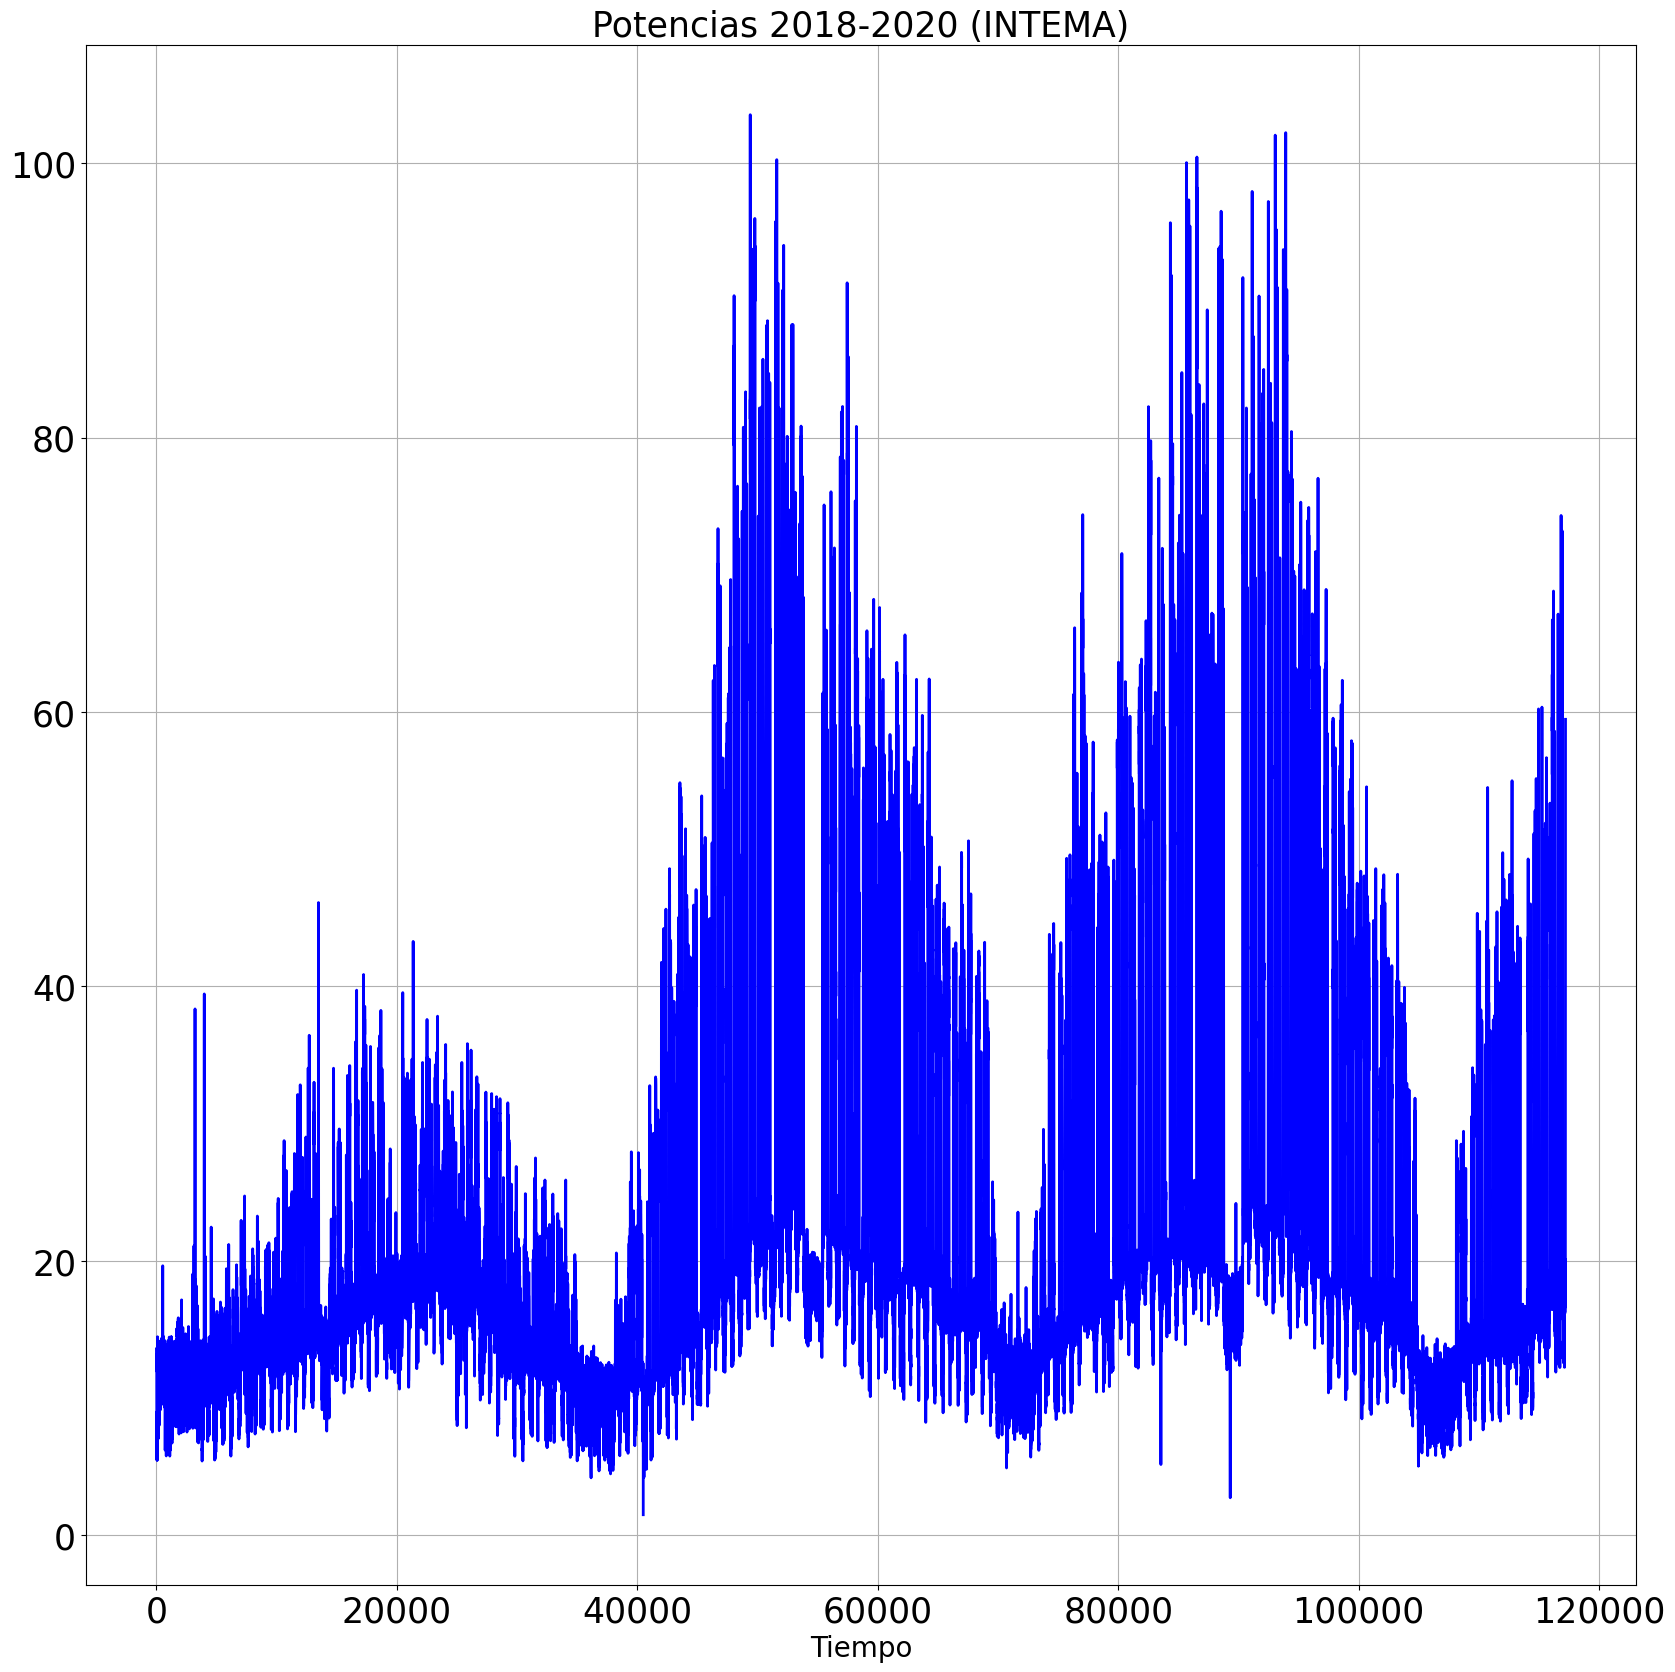

In [30]:

plt.plot(final_df["activa"],'b', linewidth = 2)
plt.rcParams['figure.figsize'] = [20, 20]

plt.grid(True)
plt.title("Potencias 2018-2020 (INTEMA)", fontsize = 25)
plt.xlabel("Tiempo", fontsize = 20)
#plt.ylabel("P [kW]", fontsize = 20)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.show


In [31]:
final_df_copy = final_df.copy()

In [74]:
final_df_copy.to_csv('dataframe.csv', index=False) 

In [75]:

# Función para crear ventanas deslizantes
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i:i-6 + window_size])  # Indexar correctamente para un array unidimensional
    return np.array(X), np.array(y)

# Crear las ventanas deslizantes
mediciones_ventana = 12


activapre, activapost = create_windows(final_df_copy['activa'], mediciones_ventana)
aparentepre, aparentepost = create_windows(final_df_copy['aparente'], mediciones_ventana)
reactivapre, reactivapost = create_windows(final_df_copy['reactiva'], mediciones_ventana)
mespre, mespost = create_windows(final_df_copy['mes'], mediciones_ventana)
diapre, diapost = create_windows(final_df_copy['dia'], mediciones_ventana)
minutopre, minutopost = create_windows(final_df_copy['minuto'], mediciones_ventana)
i1pre, i1post = create_windows(final_df_copy['l1'], mediciones_ventana)
i2pre, i2post = create_windows(final_df_copy['l2'], mediciones_ventana)
i3pre, i3post = create_windows(final_df_copy['l3'], mediciones_ventana)

#print(activapre)
print(activapost)

[[13.584 12.492 12.468 13.032 12.54  13.308]
 [12.492 12.468 13.032 12.54  13.308 12.18 ]
 [12.468 13.032 12.54  13.308 12.18  12.12 ]
 ...
 [19.188 19.272 18.048 19.38  18.216 19.788]
 [19.272 18.048 19.38  18.216 19.788 24.216]
 [18.048 19.38  18.216 19.788 24.216 29.748]]


In [96]:
hay_nans = np.isnan(final_df_copy["aparente"]).any()

if hay_nans:
    print("El vector contiene valores NaN.")
else:
    print("El vector no contiene valores NaN.")

indices_nan = np.where(pd.isna(final_df_copy["aparente"]))

# Mostrar los índices donde se encuentran NaN
print("Índices donde se encuentran NaN:", indices_nan)
print(final_df_copy["aparente"][12819])

El vector contiene valores NaN.
Índices donde se encuentran NaN: (array([12819, 17476, 17487, 17493, 17494, 17495, 17527, 17907, 40493,
       40494, 40495, 40496, 40497, 40498, 40499, 40500, 40501, 64567,
       69171], dtype=int64),)
nan


In [76]:
#Armamos los datos con el formato que queremos
X = np.concatenate([activapre, aparentepre, reactivapre, mespre, diapre, minutopre, i1pre, i2pre, i3pre], axis=1)
y = activapost  # Supongamos que queremos predecir la 'activa' post ventana

archivo_salida = 'datos.txt'

nombre_columna = 'X'

# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre las filas del array X
    for fila in X:
        # Convierte cada fila a una cadena de texto con valores separados por comas
        fila_str = ','.join(map(str, fila))
        # Escribe la fila en el archivo y añade una nueva línea
        f.write(f"{fila_str}\n")


In [36]:
# Proporciones para cada conjunto
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Divide los datos en entrenamiento y temporal (validación + prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=42)

# Calcula la proporción de validación y prueba en el conjunto temporal
val_size_temp = val_size / (val_size + test_size)

# Divide el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_size_temp), random_state=42)

# Verifica las formas de los conjuntos
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (82035, 108)
Forma de X_val: (17579, 108)
Forma de X_test: (17579, 108)
Forma de y_train: (82035, 6)
Forma de y_val: (17579, 6)
Forma de y_test: (17579, 6)


In [88]:
hay_nans = np.isnan(y).any()

if hay_nans:
    print("El vector contiene valores NaN.")
else:
    print("El vector no contiene valores NaN.")

El vector contiene valores NaN.


In [84]:

scalerX = StandardScaler()
scalery = StandardScaler()

# Assuming y is a 1D array, reshape it to 2D
y_reshaped = y.reshape(-1, 1)

# Fit and transform X and y_scaled
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.fit_transform(X_test)


y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scalery.fit_transform(y_train)
y_val = scalery.fit_transform(y_val)
y_test = scalery.fit_transform(y_test)


In [38]:
promedio = np.nanmean(y_train)
# Reemplazar NaN por el promedio calculado
y_train[np.isnan(y_train)] = promedio

promedio = np.nanmean(X_train)
# Reemplazar NaN por el promedio calculado
X_train[np.isnan(X_train)] = promedio

promedio = np.nanmean(X_val)
# Reemplazar NaN por el promedio calculado
X_val[np.isnan(X_val)] = promedio

promedio = np.nanmean(y_val)
# Reemplazar NaN por el promedio calculado
y_val[np.isnan(y_val)] = promedio

promedio = np.nanmean(X_test)
# Reemplazar NaN por el promedio calculado
X_test[np.isnan(X_test)] = promedio

promedio = np.nanmean(y_test)
# Reemplazar NaN por el promedio calculado
y_test[np.isnan(y_test)] = promedio


In [39]:
print(X_train.shape)  
print(y_train.shape) 

(82035, 108)
(492210, 1)


In [40]:
y_train = y_train.reshape(-1, 6)
y_val = y_val.reshape(-1, 6)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 60)                6540      
                                                                 
 dense_13 (Dense)            (None, 42)                2562      
                                                                 
 dense_14 (Dense)            (None, 22)                946       
                                                                 
 dense_15 (Dense)            (None, 6)                 138       
                                                                 
Total params: 10186 (39.79 KB)
Trainable params: 10186 (39.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
2564/2564 [==============================] - 7s 2ms/step - loss: 0.0140 - mae: 0.0633 - val_loss: 0.0036 - val_mae: 0.0384
Epoch 2/3
2564/25

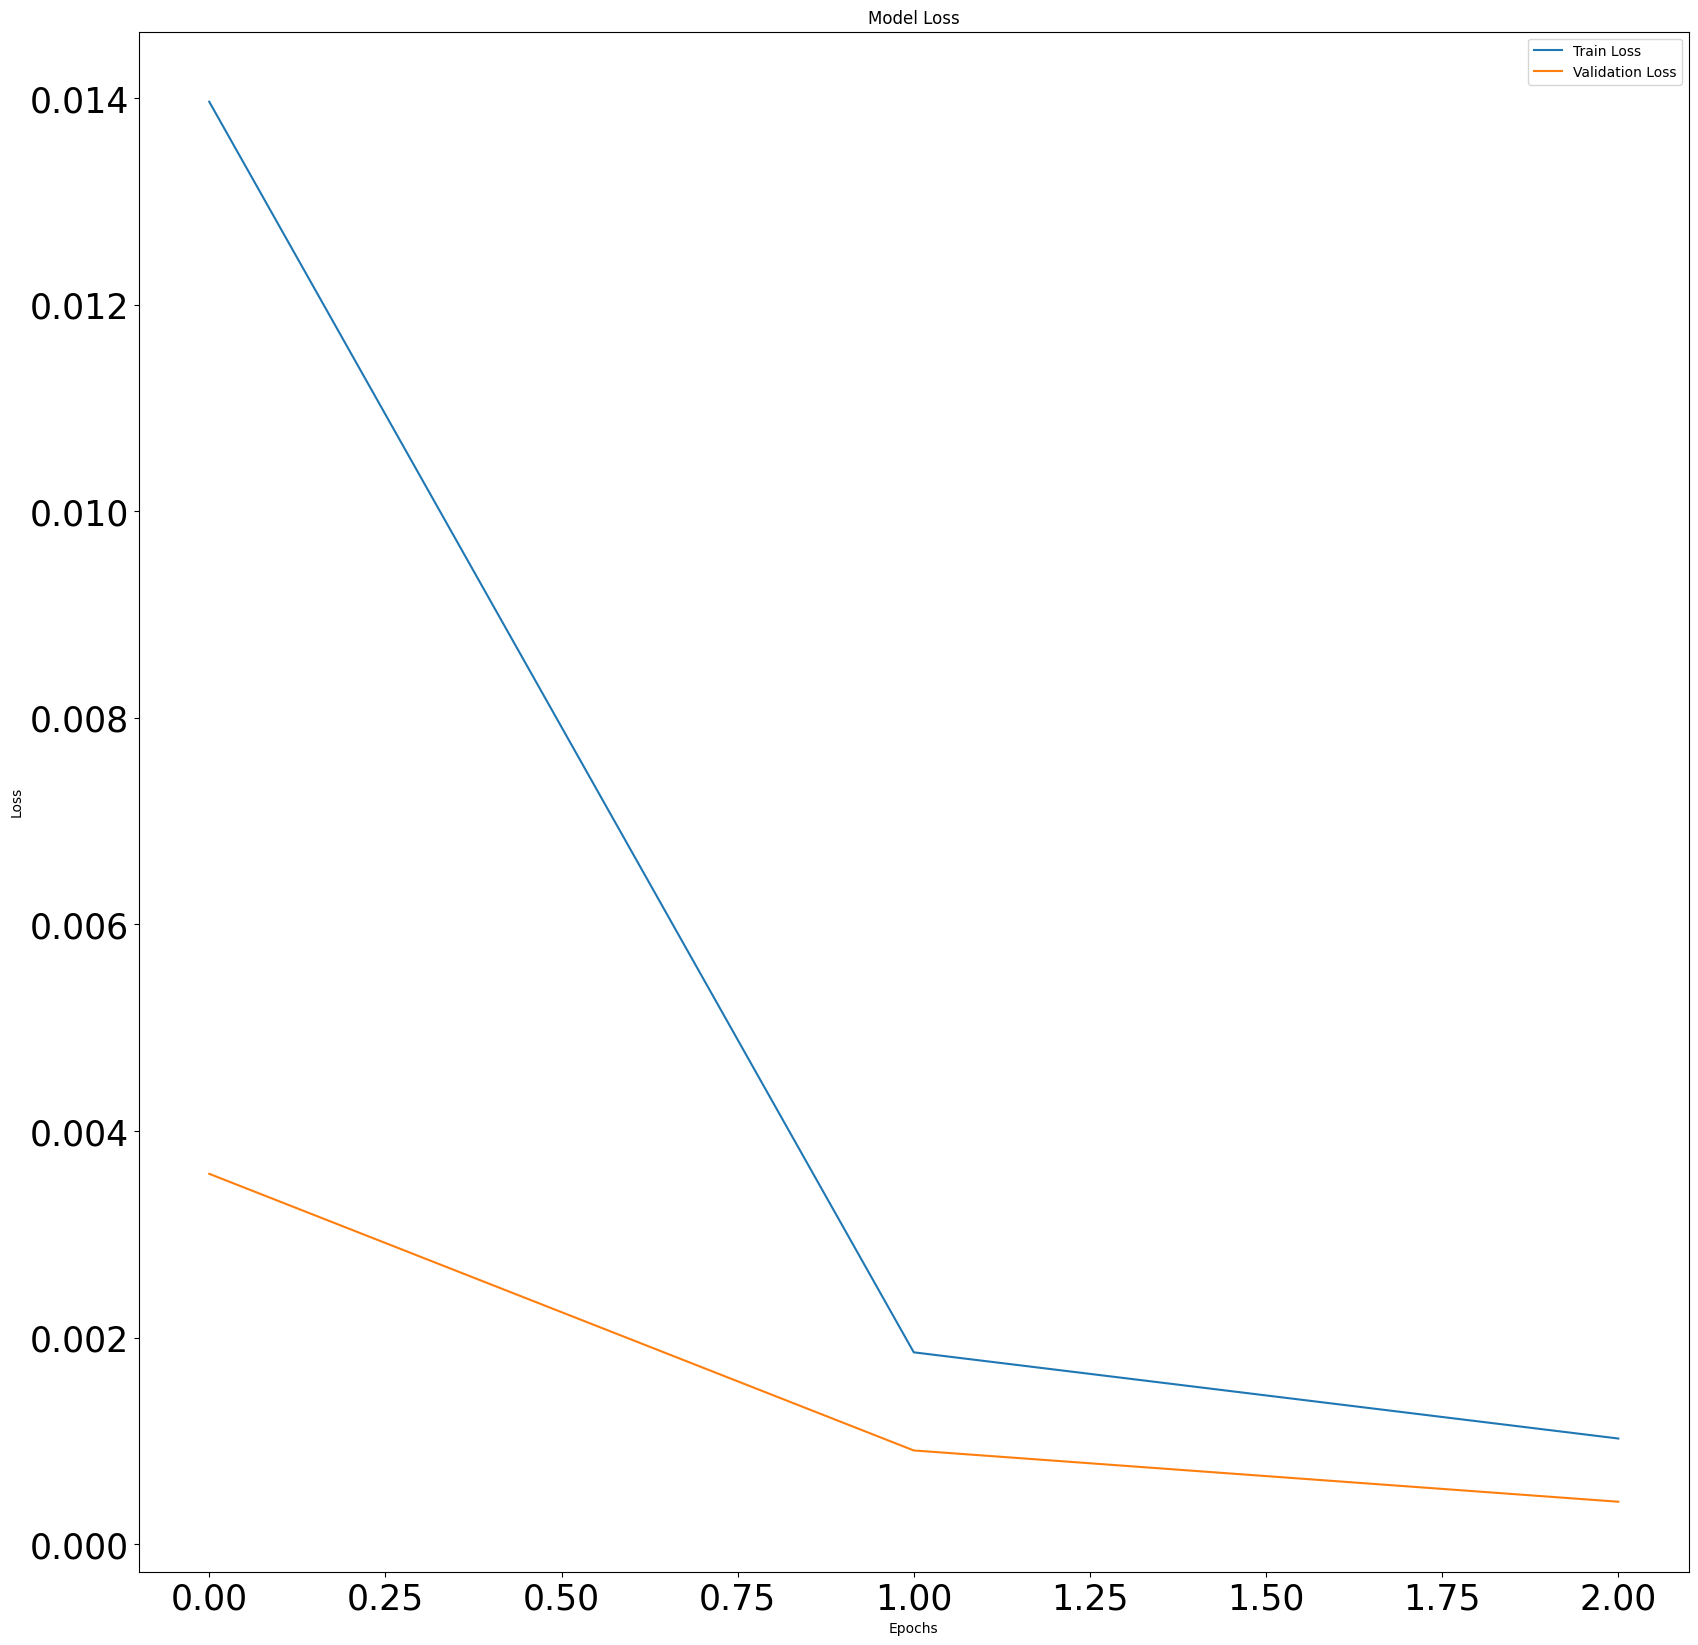

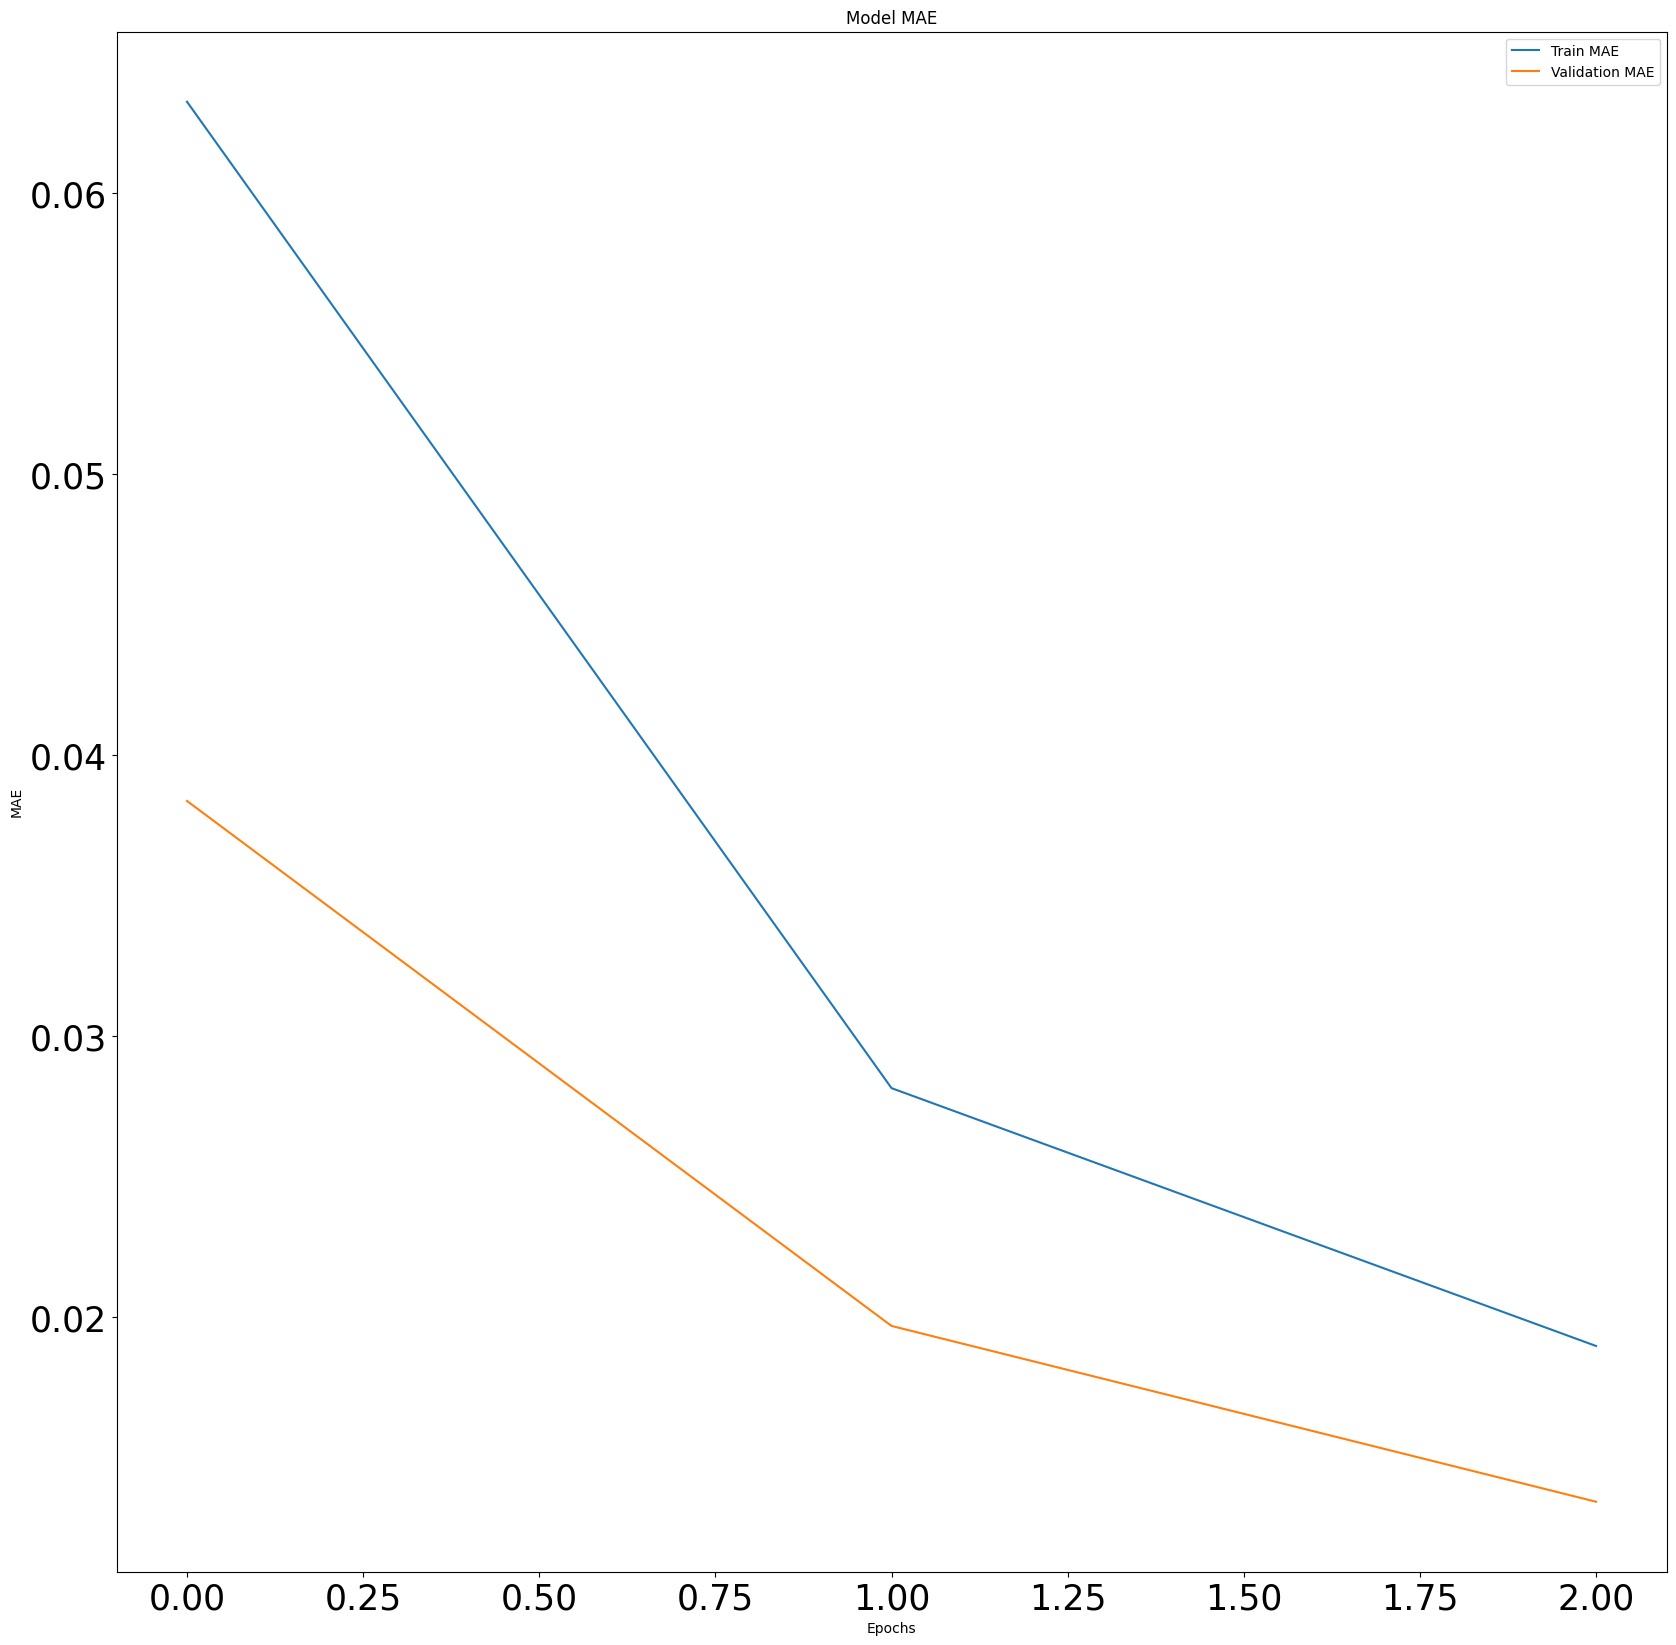

In [41]:

model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(42, activation='relu'))
model.add(Dense(22, activation='relu'))
model.add(Dense(6, activation='linear')) # Suponiendo que estás prediciendo un valor continuo

# Definir el optimizador con el learning rate deseado
optimizer = Adam(learning_rate=0.001)

# Compilar el modelo especificando el optimizador y otras configuraciones
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), callbacks=[early_stopping],  verbose=1)
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), verbose=1)


# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.axvline(x=len(history.history['loss']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica del MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.axvline(x=len(history.history['mae']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [17]:
copia_datos = X
copia_datos
copia_datos2 = copia_datos
print(copia_datos)

[[13.584 12.492 12.468 ... 20.76  20.61  20.82 ]
 [12.492 12.468 13.032 ... 20.61  20.82  19.92 ]
 [12.468 13.032 12.54  ... 20.82  19.92  20.46 ]
 ...
 [19.188 19.272 18.048 ... 59.22  62.1   80.79 ]
 [19.272 18.048 19.38  ... 62.1   80.79  73.89 ]
 [18.048 19.38  18.216 ... 80.79  73.89  71.88 ]]


In [18]:
datos_escalados = scalerX.fit_transform(copia_datos2)
print(datos_escalados)

[[-0.55768174 -0.63953185 -0.64133532 ... -0.70247127 -0.71067084
  -0.69922028]
 [-0.63952734 -0.64133066 -0.5990633  ... -0.71065924 -0.6992079
  -0.74834638]
 [-0.64132614 -0.5990587  -0.63593889 ... -0.69919609 -0.7483348
  -0.71887072]
 ...
 [-0.13766089 -0.13136895 -0.2231121  ...  1.39692392  1.55407942
   2.57421523]
 [-0.13136508 -0.22310809 -0.12327817 ...  1.55413292  2.57428145
   2.19758183]
 [-0.2231041  -0.12327432 -0.21052043 ...  2.57435383  2.19764185
   2.08786688]]


In [19]:
datos_desescalados = scalerX.inverse_transform(datos_escalados)
print(datos_desescalados)

[[13.584 12.492 12.468 ... 20.76  20.61  20.82 ]
 [12.492 12.468 13.032 ... 20.61  20.82  19.92 ]
 [12.468 13.032 12.54  ... 20.82  19.92  20.46 ]
 ...
 [19.188 19.272 18.048 ... 59.22  62.1   80.79 ]
 [19.272 18.048 19.38  ... 62.1   80.79  73.89 ]
 [18.048 19.38  18.216 ... 80.79  73.89  71.88 ]]


In [42]:
print(X_test.shape) 
X_test[7336]

(17579, 108)


array([-0.42162821, -0.65688844, -0.6244994 , -0.53835327, -0.61778543,
       -0.57823913, -0.67826769, -0.77511614, -0.67619283, -0.59771177,
       -0.62020497, -0.3400668 , -0.38075856, -0.5276176 , -0.5580359 ,
       -0.51896072, -0.5441339 , -0.51906211, -0.56350232, -0.65057115,
       -0.63216181, -0.54029267, -0.57424902, -0.37772137,  0.58544542,
        0.85701282,  0.53670665,  0.33136209,  0.58506421,  0.54433535,
        0.74763306,  0.66269321,  0.3378106 ,  0.51174849,  0.41841528,
        0.08929444, -1.46819212, -1.468261  , -1.46815786, -1.4680272 ,
       -1.46805524, -1.46821309, -1.46817152, -1.4682816 , -1.4682605 ,
       -1.46836377, -1.46842572, -1.46854925, -1.42876301, -1.42917013,
       -1.42927054, -1.42966131, -1.42968938, -1.42971497, -1.42963357,
       -1.42945483, -1.42930138, -1.42901786, -1.42942538, -1.42948701,
        0.45438898,  1.34952523, -1.3519477 , -0.44711073,  0.45443999,
        1.34948457, -1.35198916, -0.44683692,  0.45440962,  1.34

In [43]:
X_test[:,4]

archivo_salida = "datos_en_test.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for valor_y in X_test:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{valor_y}\n")


X_test_desestandarizado = scalerX.inverse_transform(X_test)
archivo_salida = "datos_en_test_desestandarizado.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in X_test_desestandarizado:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")


archivo_salida = "datos_en_x.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in X:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [44]:
y_test = scalery.inverse_transform(y_test)


In [45]:
y_test

array([[11.844],
       [11.868],
       [12.096],
       ...,
       [10.92 ],
       [10.944],
       [11.796]])

1/1 [==============================] - 0s 31ms/step
[[-0.82797354 -0.7411686  -1.0212107  -0.60033035 -0.05342084 -0.09897234]]
[[ 9.958243 11.110043  7.394215 12.978801 20.235645 19.63123 ]]
en test esa pos tenia
[10.452      11.064      10.344       1.5        20.94447652 20.94447652]


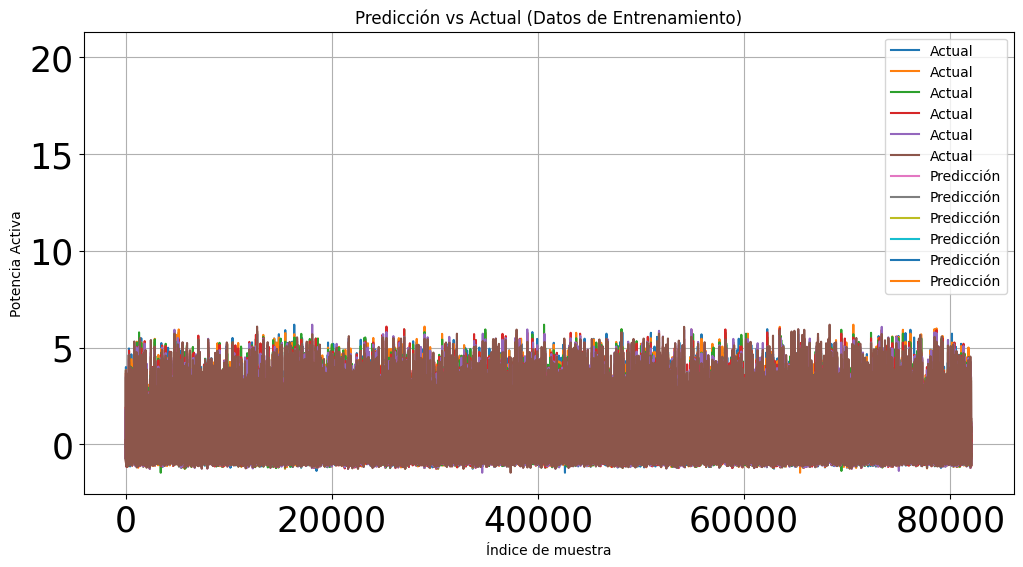

In [72]:
y_test_pred = model.predict(X_test[6108,:].reshape(1, -1))
print(y_test_pred)

y_test_pred = scalery.inverse_transform(y_test_pred)
print(y_test_pred)

#a = scalery.inverse_transform([-0.07620964])
print("en test esa pos tenia")
print(y_test[6108,:])



plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_test_pred, label='Predicción')
plt.xlabel('Índice de muestra')
plt.ylabel('Potencia Activa')
plt.title('Predicción vs Actual (Datos de Entrenamiento)')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
y_test = y_test.reshape(-1, 6)


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que model es tu modelo ya entrenado y X_test, y_test son tus datos de prueba
# Hacemos predicciones
y_test_pred = model.predict(X_test)

has_nan = np.isnan(y_test_pred).any()
print("¿Hay NaN en los datos y_test_pred?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test_pred))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test_pred[np.isnan(y_test_pred)] = promedio

y_test_pred = scalery.inverse_transform(y_test_pred)



has_nan = np.isnan(y_test).any()
print("¿Hay NaN en los datos y_Test?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test[np.isnan(y_test)] = promedio


# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_test_pred)



# Calculamos otras métricas de error
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(y_test - y_test_pred) <= margin_of_error)
total_predictions = len(y_test)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')

print(y_test_pred)
print(y_test)



550/550 [==============================] - 1s 2ms/step
¿Hay NaN en los datos y_test_pred? False
Posiciones de NaN en los datos X:
[]
¿Hay NaN en los datos y_Test? False
Posiciones de NaN en los datos X:
[]
MSE: 0.08000407744770799
MAE: 0.18057164590184835
RMSE: 0.28284992036008777
R²: 0.9995456049982742
Número de predicciones dentro del margen de error: 105455
Precisión dentro del margen de error: 599.89%
[[11.74712   12.185799  12.093833  12.276925  12.65375   12.659102 ]
 [ 7.8470845  8.612389   8.698438   8.526328   8.590315   9.148395 ]
 [11.568459  12.144366  12.011245  11.885506  10.913528  12.124152 ]
 ...
 [22.46157   22.24912   22.354263  22.8613    23.874538  23.030396 ]
 [12.7196455 12.217665  12.568252  13.179451  13.141025  13.078527 ]
 [10.189026  10.672381  11.231754  11.021449  11.089465  12.020084 ]]
[[11.844 11.868 12.096 12.3   12.672 12.6  ]
 [ 8.04   8.448  8.628  8.592  8.388  8.784]
 [11.7   12.    11.964 12.036 11.064 12.048]
 ...
 [22.476 22.044 22.164 22.86  2

In [ ]:
archivo_salida = "datos_estimados.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test_pred:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [ ]:
archivo_salida = "datos_en_y_test.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

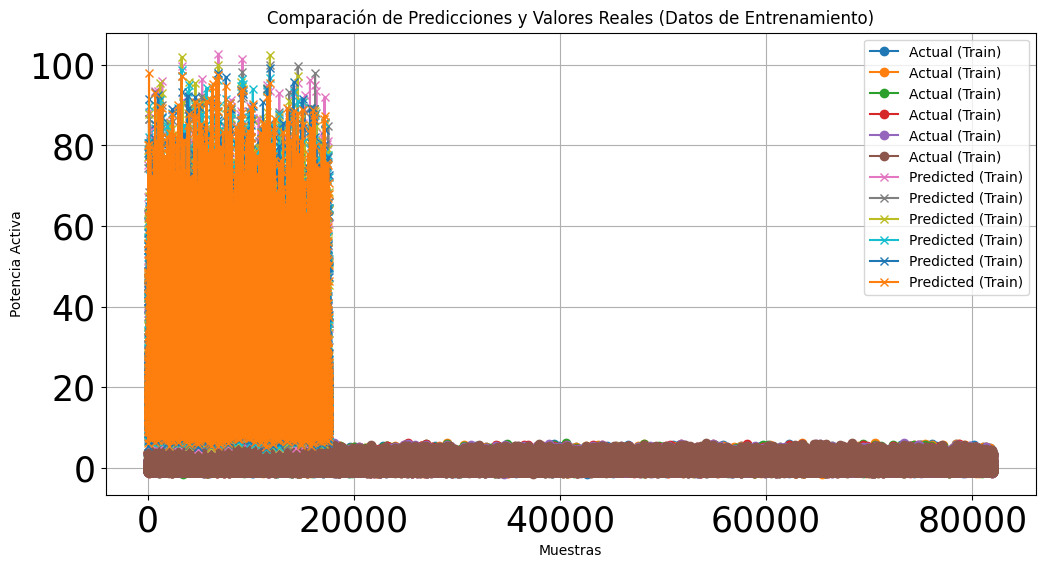

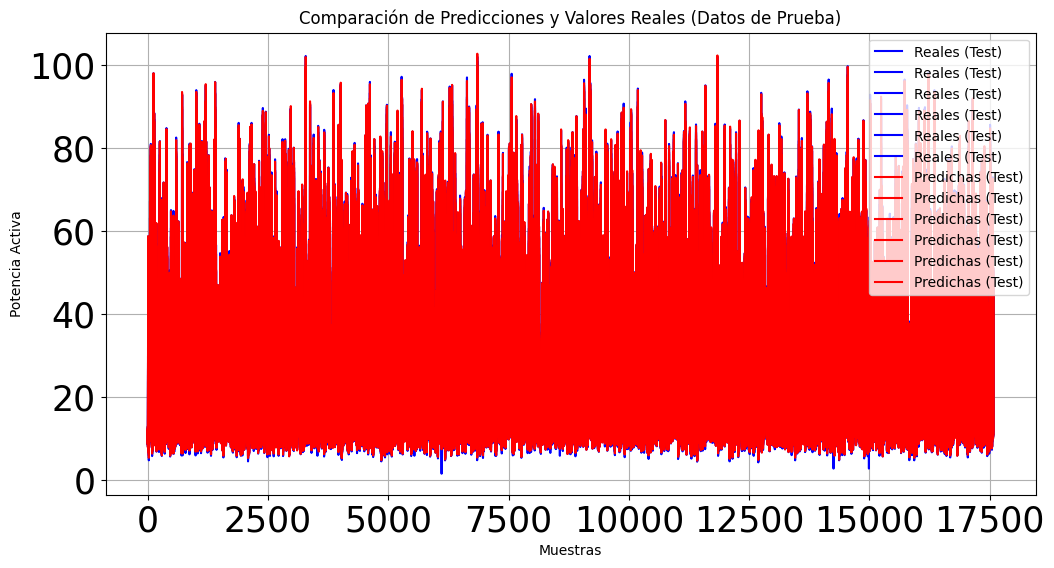

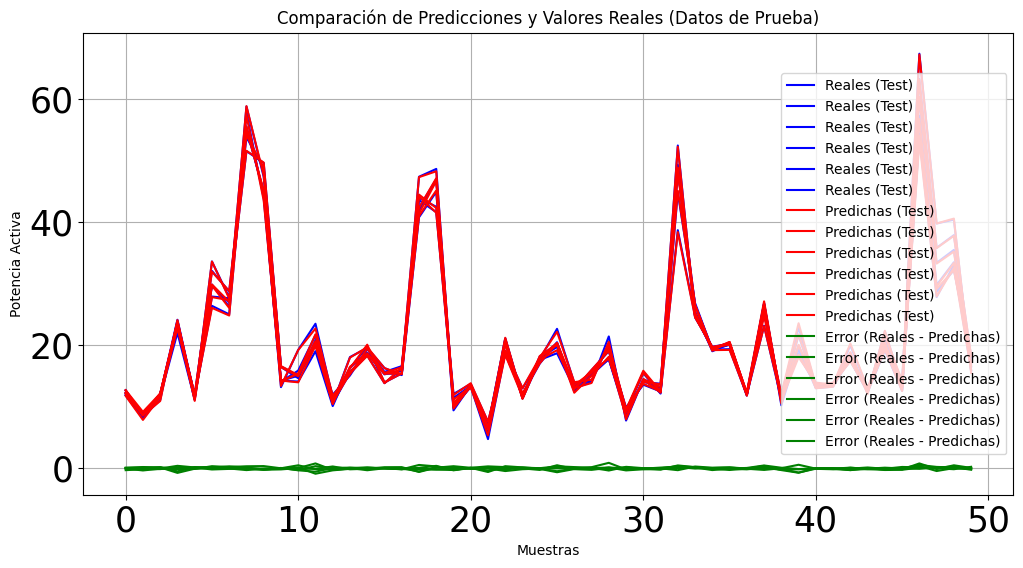

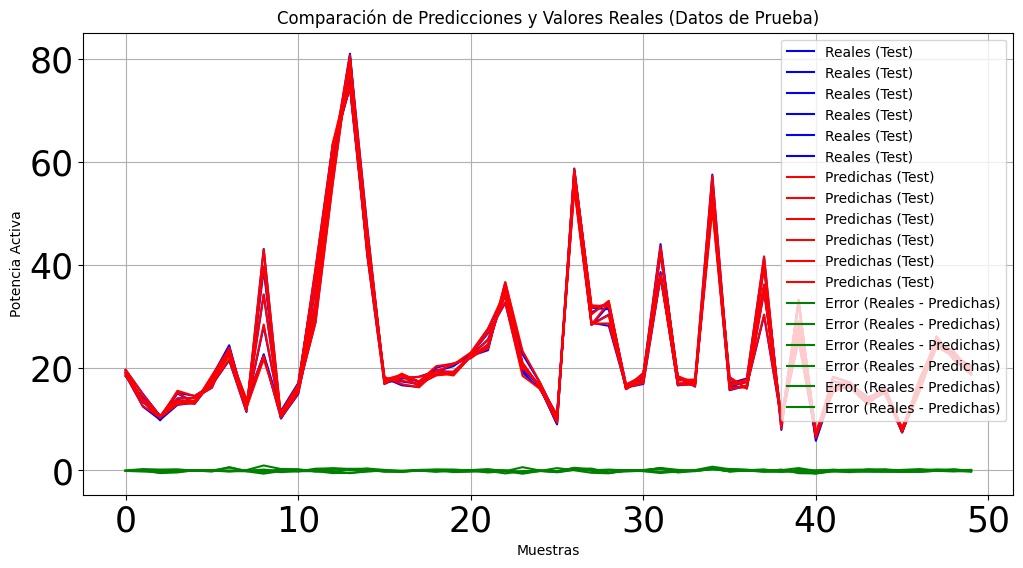

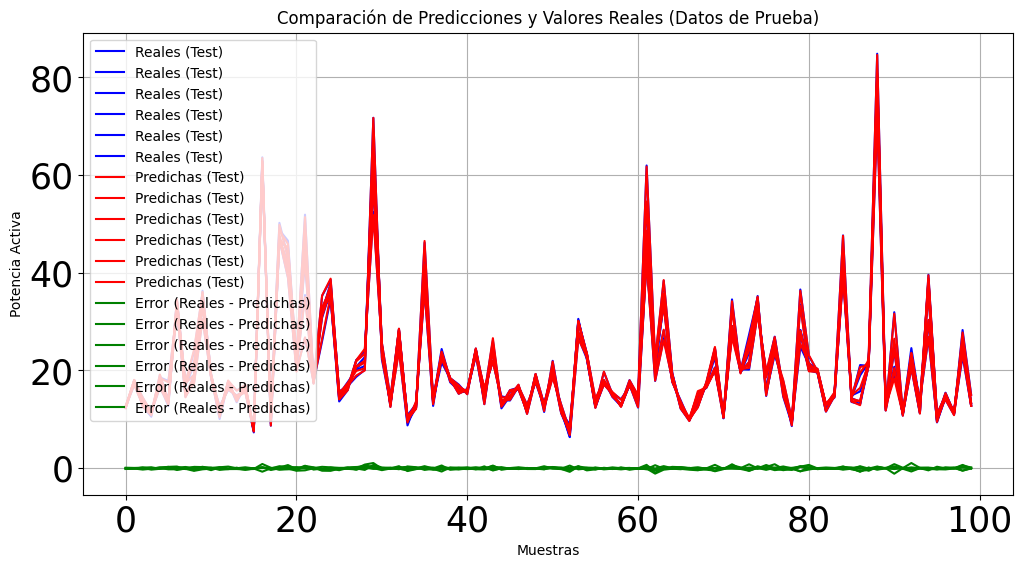

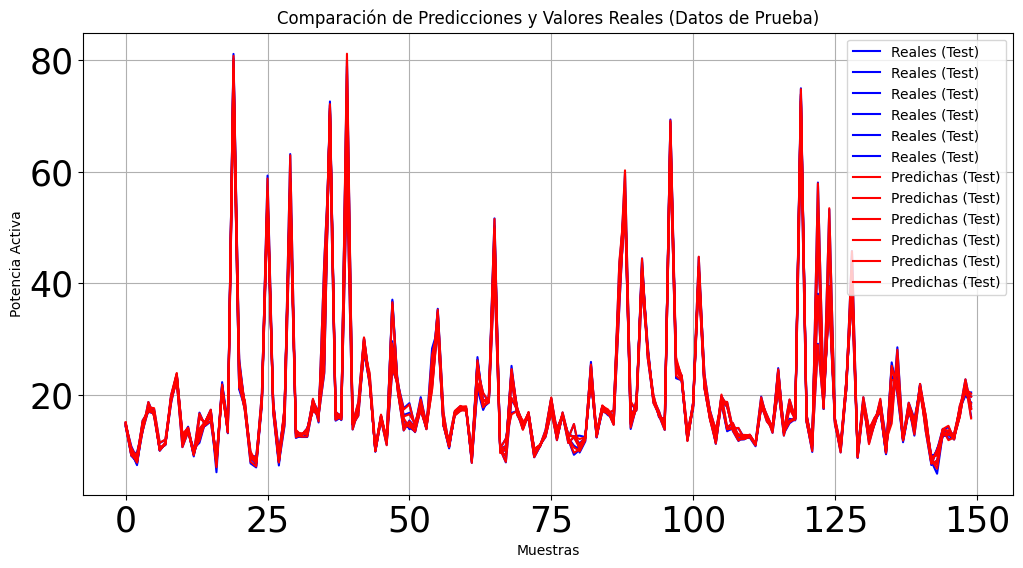

[[ 0.0968801  -0.31779865  0.00216703  0.02307491  0.01824958 -0.05910244]
 [ 0.19291548 -0.16438861 -0.07043769  0.06567191 -0.20231487 -0.36439458]
 [ 0.13154144 -0.14436626 -0.04724477  0.15049432  0.15047156 -0.07615218]
 ...
 [ 0.01442926 -0.20512071 -0.19026331 -0.00129951 -0.36653842 -0.51839551]
 [-0.0116455  -0.12166472  0.04374839  0.04454901  0.09497541 -0.09452745]
 [ 0.25097412 -0.0043814  -0.1677543  -0.10144909 -0.14546514 -0.22408438]]


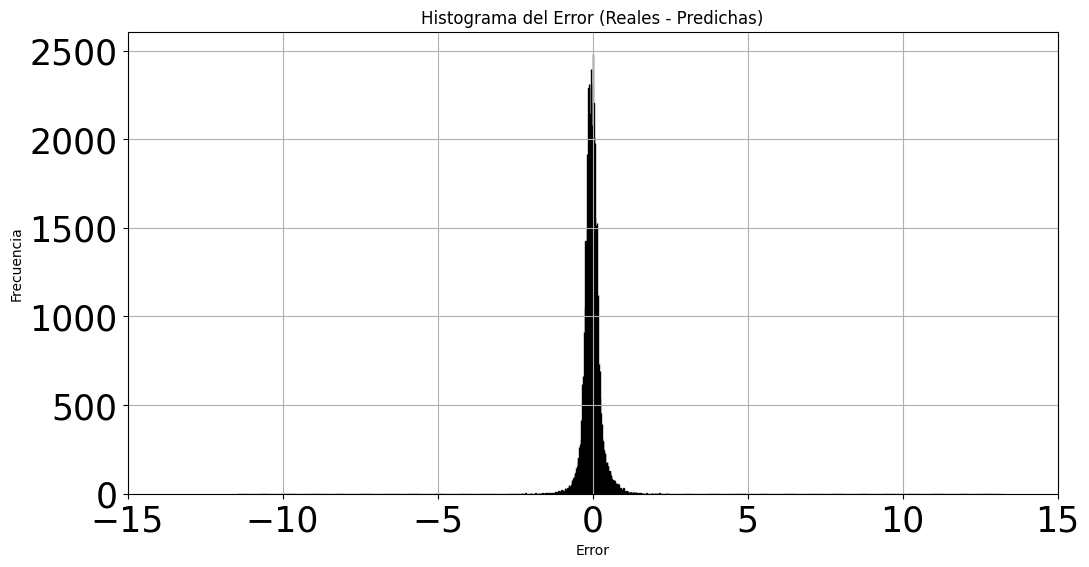

In [50]:

# Plot de datos de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual (Train)', marker='o')
plt.plot(y_test_pred, label='Predicted (Train)', marker='x')
plt.title('Comparación de Predicciones y Valores Reales (Datos de Entrenamiento)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')
plt.legend()
plt.grid(True)
plt.show()

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los datos reales y predichos como líneas
plt.plot(y_test, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred, label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()



# Calculamos el error (diferencia entre los valores reales y predichos)
error = y_test[:50] - y_test_pred[:50]

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 50 datos reales y predichos como líneas
plt.plot(y_test[:50], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[:50], label='Predichas (Test)', linestyle='-', color='red')

# Ploteamos el error como línea
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()






# Plot de datos de prueba
plt.figure(figsize=(12, 6))

error = y_test[50:100] - y_test_pred[50:100]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[50:100], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[50:100], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = y_test[300:400] - y_test_pred[300:400]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[300:400], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[300:400], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()





# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[850:1000], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[850:1000], label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


error = y_test - y_test_pred
print((error))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

In [58]:
y_test

array([[22.476, 22.2  ],
       [35.688, 35.7  ],
       [21.72 , 21.324],
       ...,
       [14.148, 14.844],
       [15.696, 14.22 ],
       [17.412, 17.196]])

[ 0.0968801   0.19291548  0.13154144 ...  0.01442926 -0.0116455
  0.25097412]
Desviación estándar del error: 0.30


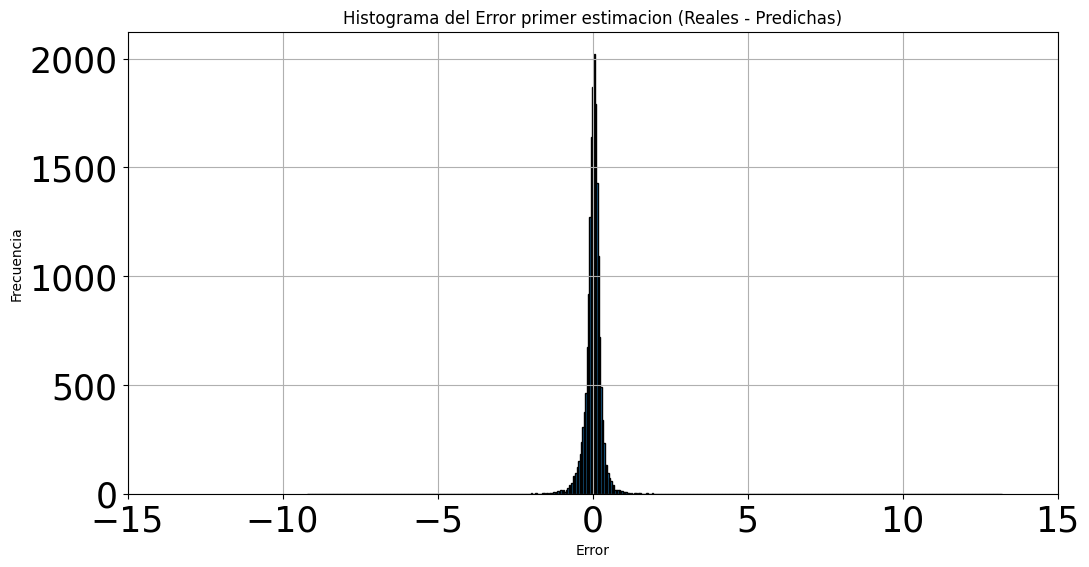

In [51]:
error1 = y_test[:,0] - y_test_pred[:,0]
print((error1))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error1, bins=500, edgecolor='black')

# Añadimos título y etiquetas
plt.title('Histograma del Error primer estimacion (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

std_deviation1 = np.std(error1)

print(f"Desviación estándar del error: {std_deviation1:.2f}")

# Mostramos el gráfico
plt.grid(True)
plt.show()


[ 0.0968801   0.19291548  0.13154144 ...  0.01442926 -0.0116455
  0.25097412]
Desviación estándar del error: 0.27


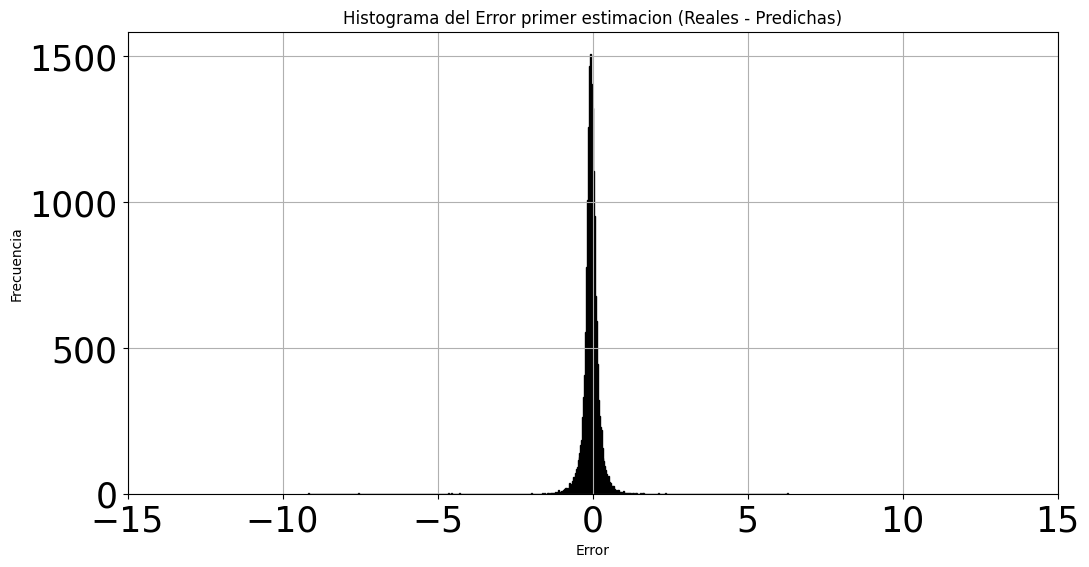

In [52]:
error2 = y_test[:,1] - y_test_pred[:,1]
print((error1))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error2, bins=500, edgecolor='black')

# Añadimos título y etiquetas
plt.title('Histograma del Error primer estimacion (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

std_deviation2 = np.std(error2)

print(f"Desviación estándar del error: {std_deviation2:.2f}")

# Mostramos el gráfico
plt.grid(True)
plt.show()


In [53]:
std_deviation = np.std(error)

print(f"Desviación estándar del error: {std_deviation:.2f}")

Desviación estándar del error: 0.28


In [54]:
error

array([[ 0.0968801 , -0.31779865,  0.00216703,  0.02307491,  0.01824958,
        -0.05910244],
       [ 0.19291548, -0.16438861, -0.07043769,  0.06567191, -0.20231487,
        -0.36439458],
       [ 0.13154144, -0.14436626, -0.04724477,  0.15049432,  0.15047156,
        -0.07615218],
       ...,
       [ 0.01442926, -0.20512071, -0.19026331, -0.00129951, -0.36653842,
        -0.51839551],
       [-0.0116455 , -0.12166472,  0.04374839,  0.04454901,  0.09497541,
        -0.09452745],
       [ 0.25097412, -0.0043814 , -0.1677543 , -0.10144909, -0.14546514,
        -0.22408438]])

In [64]:
error

array([[ 0.0968801 , -0.31779865,  0.00216703,  0.02307491,  0.01824958,
        -0.05910244],
       [ 0.19291548, -0.16438861, -0.07043769,  0.06567191, -0.20231487,
        -0.36439458],
       [ 0.13154144, -0.14436626, -0.04724477,  0.15049432,  0.15047156,
        -0.07615218],
       ...,
       [ 0.01442926, -0.20512071, -0.19026331, -0.00129951, -0.36653842,
        -0.51839551],
       [-0.0116455 , -0.12166472,  0.04374839,  0.04454901,  0.09497541,
        -0.09452745],
       [ 0.25097412, -0.0043814 , -0.1677543 , -0.10144909, -0.14546514,
        -0.22408438]])

In [71]:
min_error = np.min(error)
max_error = np.max(error)


# Encontrar los índices de los valores que tienen un valor absoluto mayor que 1
indices = np.where(np.abs(error) > 2)
# Contar cuántos valores cumplen la condición
cont = len(indices[0])

with open("resultados.txt", "w") as file:
    file.write(f"Valor minimo del error: {min_error}\n")
    file.write(f"Valor maximo del error: {max_error}\n")
    file.write(f"Cantidad de valores con modulo mayor que el elegido: {cont}\n")

    file.write("Posiciones y valores:\n")
    for i in range(cont):
        row = indices[0][i]
        col = indices[1][i]
        file.write(f"indice: ({row}, {col}), Valor: {error[row, col]}\n")


In [55]:
y_test

array([[11.844, 11.868, 12.096, 12.3  , 12.672, 12.6  ],
       [ 8.04 ,  8.448,  8.628,  8.592,  8.388,  8.784],
       [11.7  , 12.   , 11.964, 12.036, 11.064, 12.048],
       ...,
       [22.476, 22.044, 22.164, 22.86 , 23.508, 22.512],
       [12.708, 12.096, 12.612, 13.224, 13.236, 12.984],
       [10.44 , 10.668, 11.064, 10.92 , 10.944, 11.796]])

In [56]:
y_test_pred

array([[11.74712  , 12.185799 , 12.093833 , 12.276925 , 12.65375  ,
        12.659102 ],
       [ 7.8470845,  8.612389 ,  8.698438 ,  8.526328 ,  8.590315 ,
         9.148395 ],
       [11.568459 , 12.144366 , 12.011245 , 11.885506 , 10.913528 ,
        12.124152 ],
       ...,
       [22.46157  , 22.24912  , 22.354263 , 22.8613   , 23.874538 ,
        23.030396 ],
       [12.7196455, 12.217665 , 12.568252 , 13.179451 , 13.141025 ,
        13.078527 ],
       [10.189026 , 10.672381 , 11.231754 , 11.021449 , 11.089465 ,
        12.020084 ]], dtype=float32)